# Загрузка данных и подготовка их к анализу

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

visits=pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs=pd.read_csv('/datasets/costs_info_short.csv')

visits.isna().sum() #пропусков нет
visits.duplicated().sum() #дубликатов нет
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]


orders.isna().sum() #пропусков нет
orders.duplicated().sum() #дубликатов нет
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]

costs.isna().sum() #пропусков нет
costs.duplicated().sum() #дубликатов нет
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns]

visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])

orders['event_dt']=pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [19]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [20]:
#Удержание
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [21]:
#конверсия
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

# Исследовательский анализ данных

Создаю пользовательские профили. Определяю минимальную и максимальную даты привлечения пользователей.

In [22]:
# функция для получения пользовательских профилей
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

In [23]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
#purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

profiles = get_profiles(visits, orders, costs)  # профили с CAC
min_day=profiles['first_ts'].min()
max_day=profiles['first_ts'].max()
print(f'Максимальная дата привлечения пользователей {max_day}')
print(f'Минимальная дата привлечения пользователей {min_day}')

Максимальная дата привлечения пользователей 2019-10-27 23:59:04
Минимальная дата привлечения пользователей 2019-05-01 00:00:41


Выясняю, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Строю таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [24]:
test=profiles.groupby(['region']).agg({'user_id': 'count', 'payer': 'sum'})

test['percent_payers']=test['payer']/test['user_id']*100
test['percent_payers']=test['percent_payers'].round(2)
test.rename(columns = {'user_id' : 'count_users', 
                         'payer' : 'count_payers'}, inplace = True)
test=test.sort_values(by='count_payers', ascending=False)

print(test)
print()
print('Вывод: Платащие пользователи чаще всего из United States')

               count_users  count_payers  percent_payers
region                                                  
United States       100002          6902            6.90
UK                   17575           700            3.98
France               17450           663            3.80
Germany              14981           616            4.11

Вывод: Платащие пользователи чаще всего из United States


Узнаю, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Строю таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [25]:
test1=profiles.groupby(['device']).agg({'user_id': 'count', 'payer': 'sum'})
test1.rename(columns = {'user_id' : 'count_users', 
                         'payer' : 'count_payers'}, inplace = True)
test1['percent_payers']=test1['count_payers']/test1['count_users']*100
test1['percent_payers']=test1['percent_payers'].round(2)
test1=test1.sort_values(by='count_payers', ascending=False)

print(test1)
print()
print('Вывод: Платащие пользователи чаще всего предпочитают устройства iPhone')
print('Конверсия каналов произодителя Apple самая высокая и составляет 6.21% для iPhone и 6.36% для Mac')

         count_users  count_payers  percent_payers
device                                            
iPhone         54479          3382            6.21
Android        35032          2050            5.85
Mac            30042          1912            6.36
PC             30455          1537            5.05

Вывод: Платащие пользователи чаще всего предпочитают устройства iPhone
Конверсия каналов произодителя Apple самая высокая и составляет 6.21% для iPhone и 6.36% для Mac


Изучаю рекламные источники привлечения и определяю каналы, из которых пришло больше всего платящих пользователей. Визуализирую таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [26]:
test2=profiles.groupby(['channel']).agg({'user_id': 'count', 'payer': 'sum'})
test2.rename(columns = {'user_id' : 'count_users', 
                         'payer' : 'count_payers'}, inplace = True)
test2['percent_payers']=test2['count_payers']/test2['count_users']*100
test2['percent_payers']=test2['percent_payers'].round(2)
test2=test2.sort_values(by='count_payers', ascending=False)

print(test2)
print()
print('Вывод: Платащие пользователи чаще приходят из канала FaceBoom')
print('Конверсия этого канала, так же самая высокая и составляет 12.2%')

                    count_users  count_payers  percent_payers
channel                                                      
FaceBoom                  29144          3557           12.20
TipTop                    19561          1878            9.60
organic                   56439          1160            2.06
WahooNetBanner             8553           453            5.30
AdNonSense                 3880           440           11.34
RocketSuperAds             4448           352            7.91
LeapBob                    8553           262            3.06
OppleCreativeMedia         8605           233            2.71
lambdaMediaAds             2149           225           10.47
YRabbit                    4312           165            3.83
MediaTornado               4364           156            3.57

Вывод: Платащие пользователи чаще приходят из канала FaceBoom
Конверсия этого канала, так же самая высокая и составляет 12.2%


# Маркетинг

Считаю общую сумму расходов на маркетинг. Выясняю, как траты распределены по источникам. Визуализирую изменения метрик во времени.

                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22

Вывод: Подавляющее количество рекламного бюджета тратятся на два канала TipTop и FaceBoom
Общая сумма трат на рекламу 105497.3


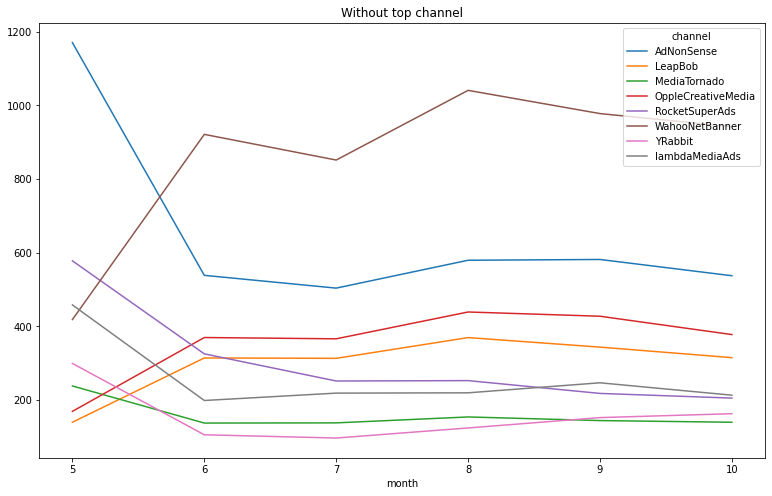

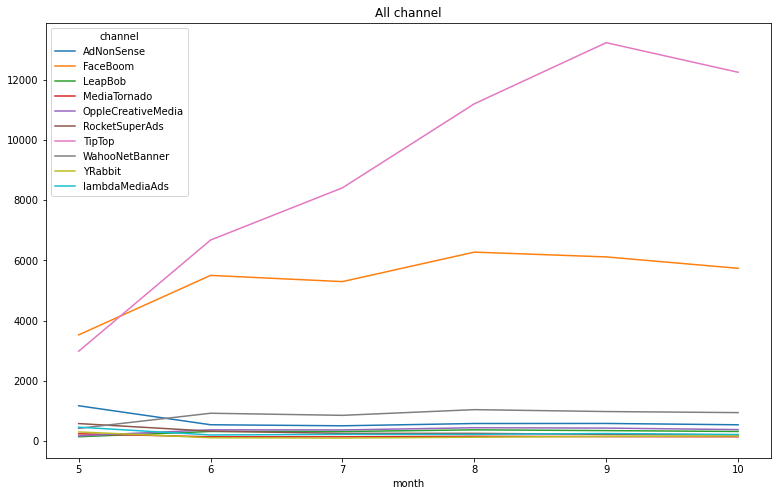

In [27]:
total_ad_costs=costs['costs'].sum().round(2)

total_channel=costs.groupby(['channel']).agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
print(total_channel)

costs['month']=pd.to_datetime(costs['dt']).dt.month
costs.query('channel != ["TipTop", "FaceBoom"]').pivot_table(columns='channel', values='costs', index='month', aggfunc = 'sum').plot(title='Without top channel', figsize=(13, 8))
costs.pivot_table(columns='channel', values='costs', index='month', aggfunc = 'sum').plot(title='All channel', figsize=(13, 8))

print()
print('Вывод: Подавляющее количество рекламного бюджета тратятся на два канала TipTop и FaceBoom')
print(f'Общая сумма трат на рекламу {total_ad_costs}')

# Оценка окупаемости рекламы для привлечения пользователей

In [28]:
# функция для сглаживания датафрейма
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 
    
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
    
    

# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Анализ общей окупаемости рекламы

In [29]:
profiles1=profiles.query('channel != "organic"') #удаляю из выборки органический канал трафика

observation_date=datetime(2019, 11, 1).date()
horizon_days=14

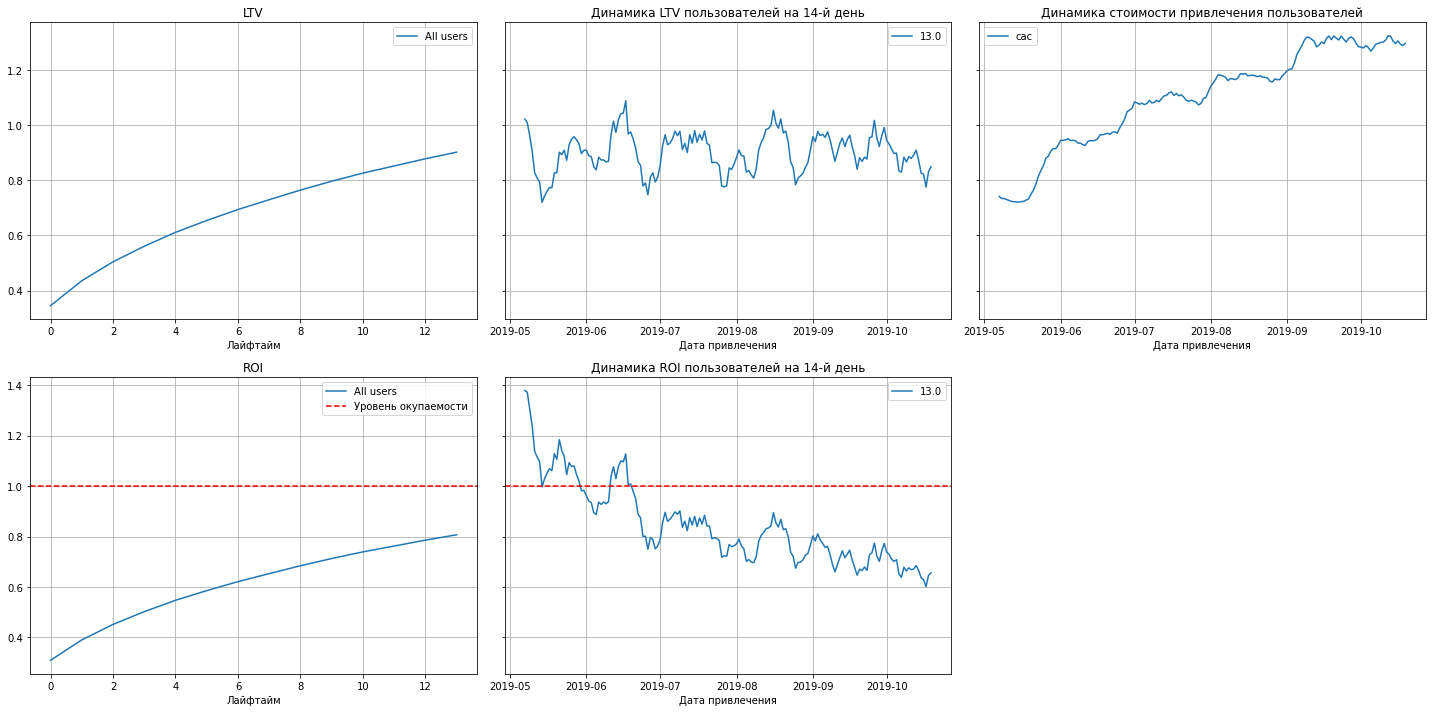

In [30]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles1, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

### Анализ окупаемости рекламы с разбивкой по устройствам

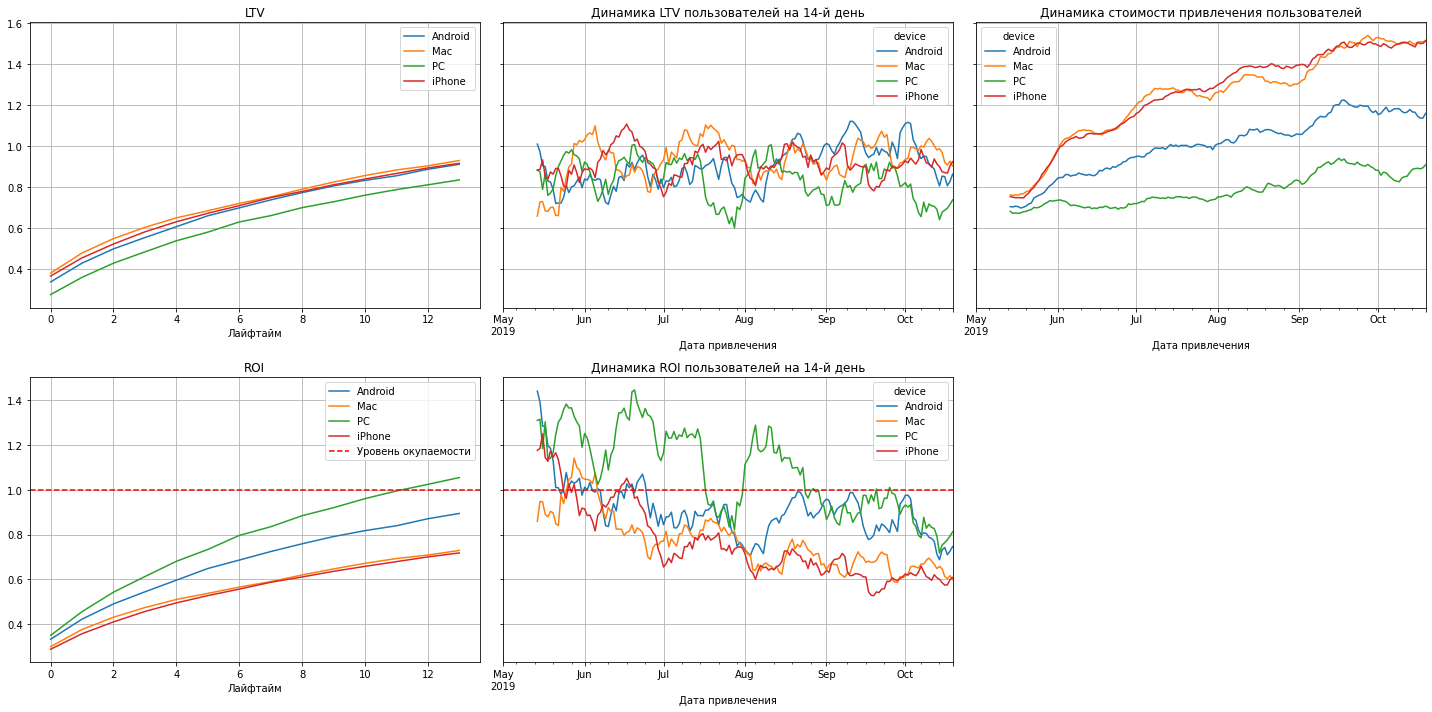

In [32]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

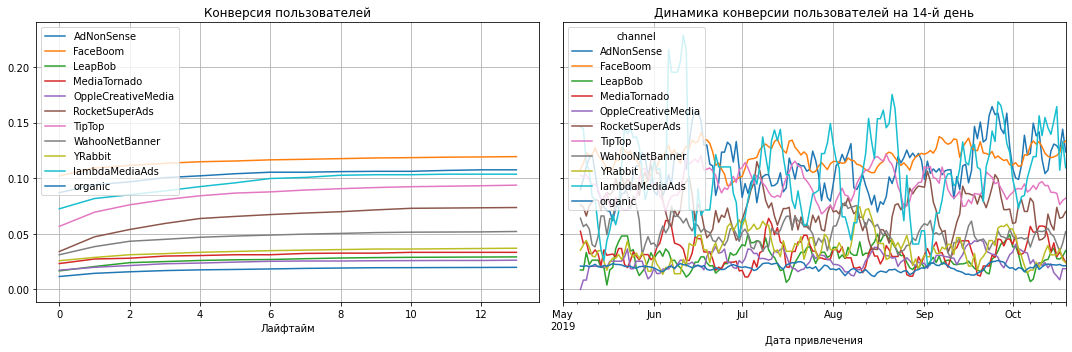

In [37]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

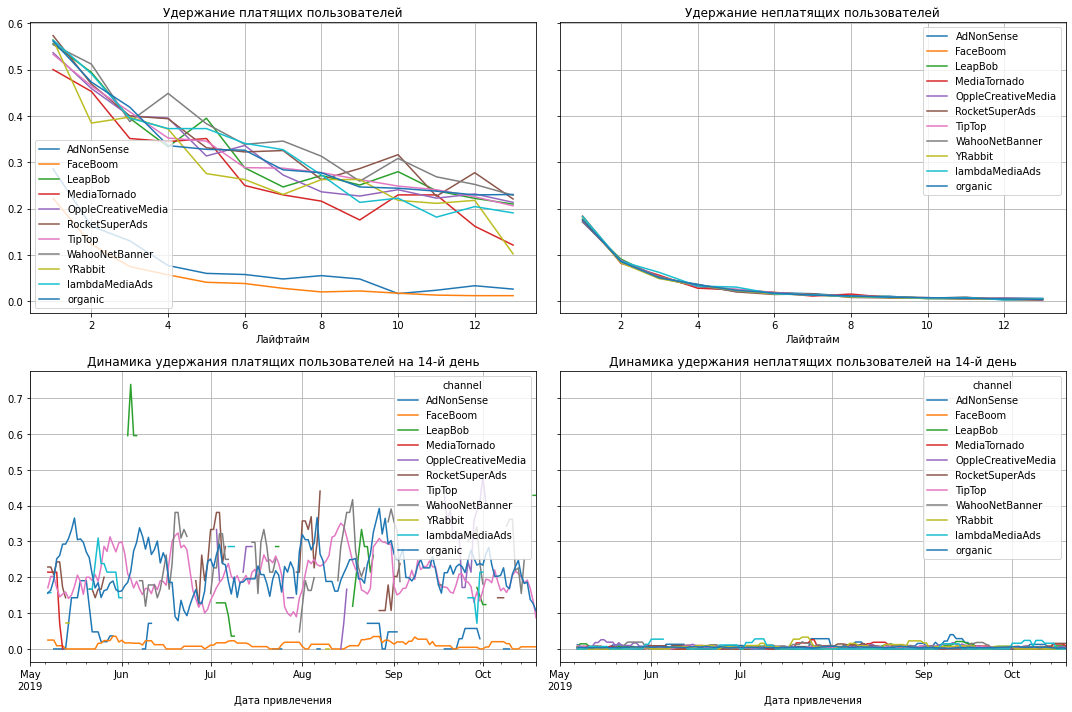

In [38]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Анализ окупаемости рекламы с разбивкой по странам

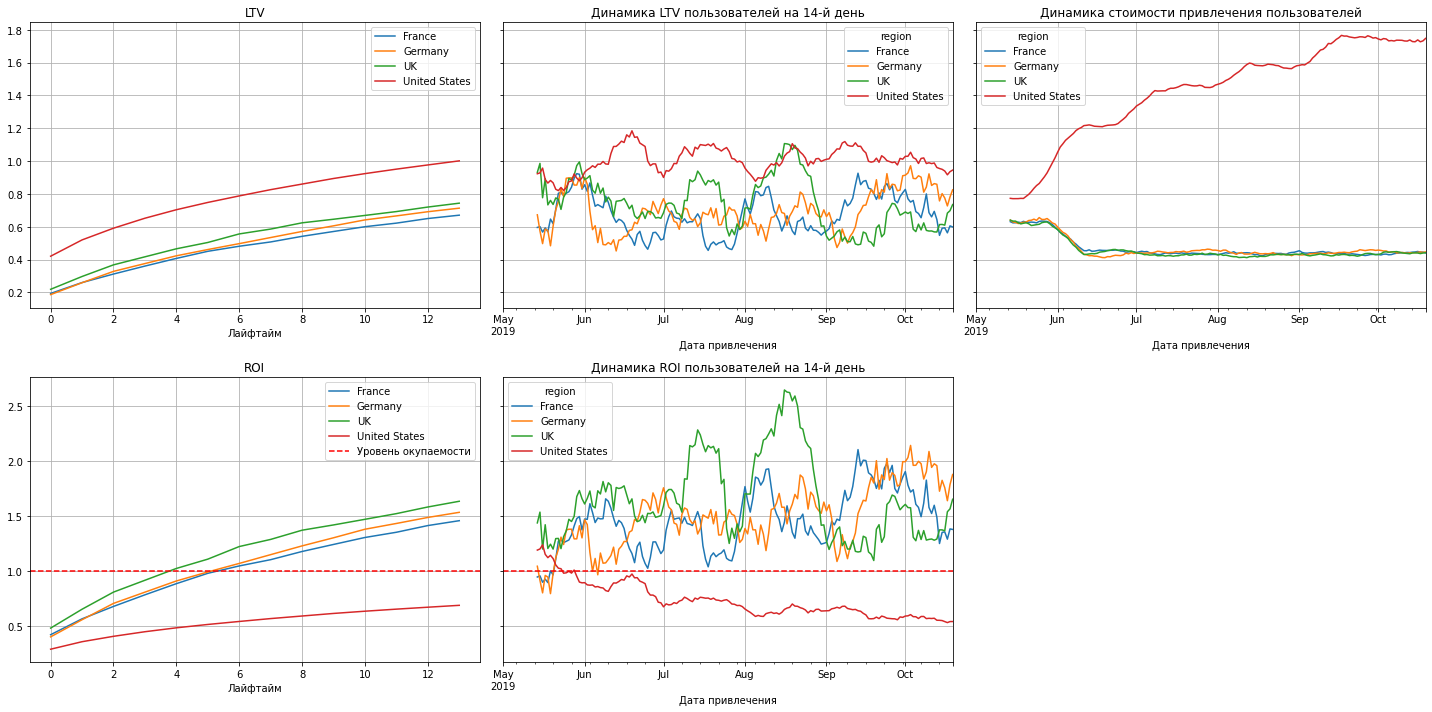

In [39]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

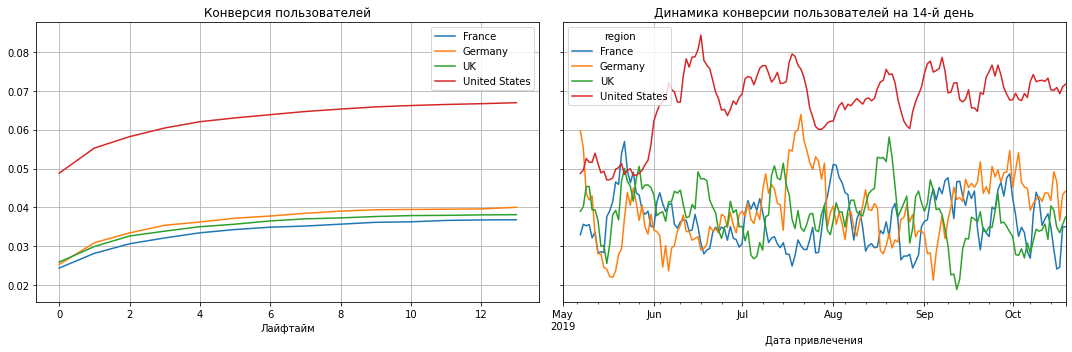

In [40]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

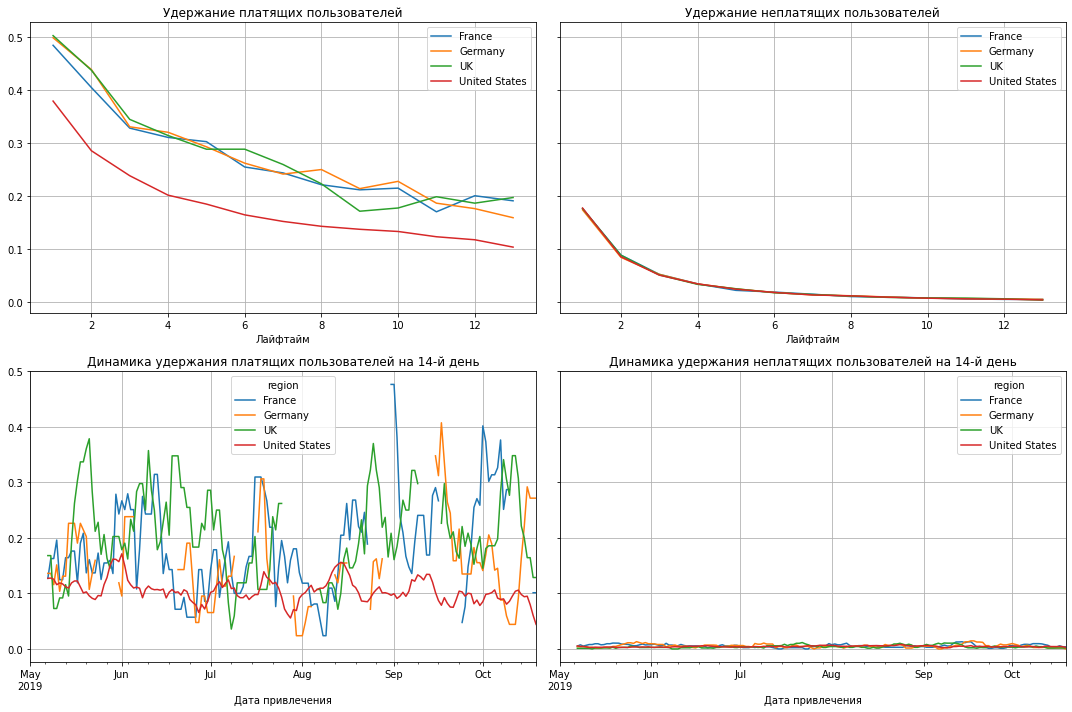

In [41]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

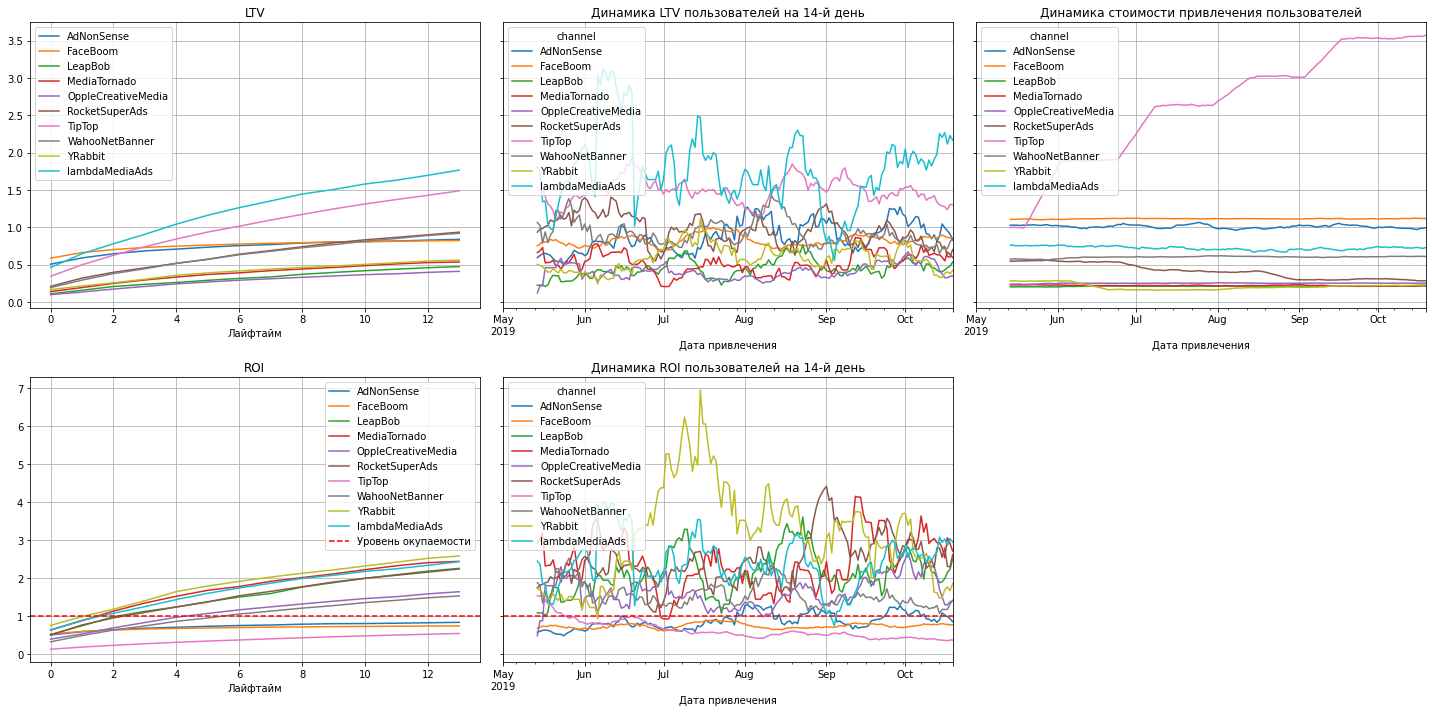

In [42]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

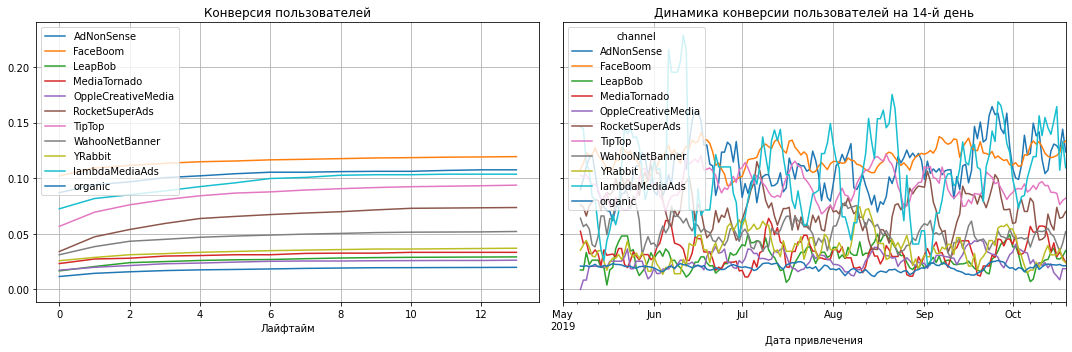

In [43]:
# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

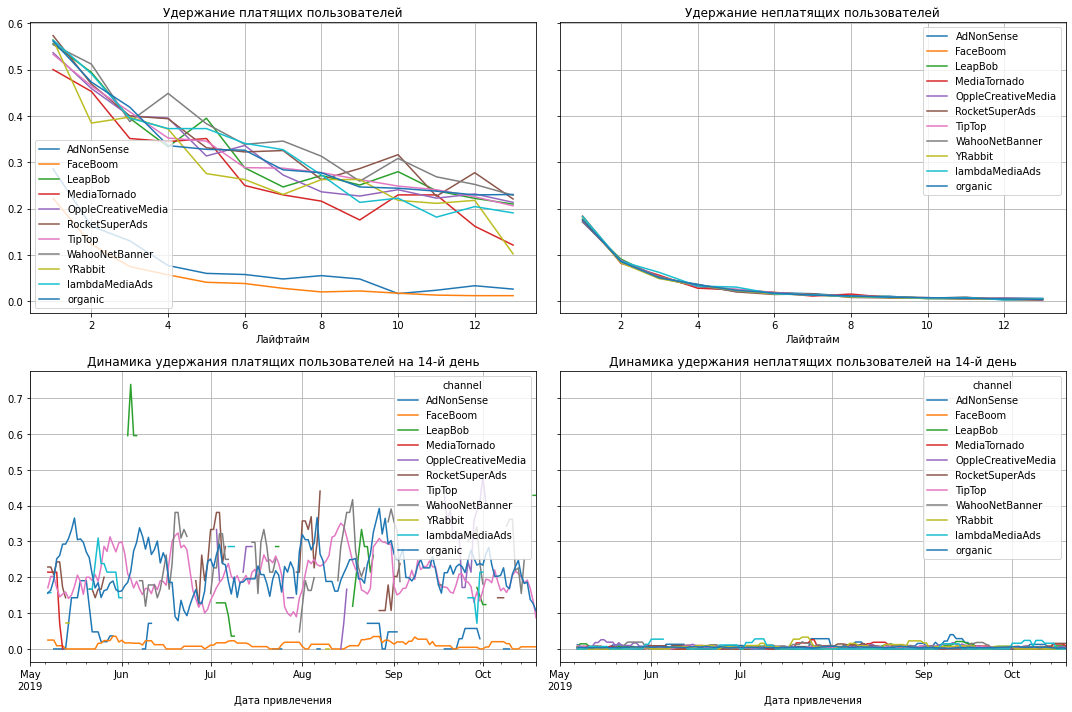

In [44]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

In [45]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14
)

max_acquisition_date = roi_history.reset_index()['dt'].max()

# сравниваем расходы на привлечение в таблице ROI и тратах на рекламу

print(
   'Общие расходы на привлечение из таблицы ROI: {:.2f}'.format(
       roi.loc['All users', 'cac'] * roi.loc['All users', 'cohort_size']
   )
)

print(
   'Общие расходы на привлечение из таблицы costs: {:.2f}'.format(
       costs.query('dt <= @max_acquisition_date')['costs'].sum()
   )
) 


print('Результаты совпадают — CAC посчитан верно.')

Общие расходы на привлечение из таблицы ROI: 99085.74
Общие расходы на привлечение из таблицы costs: 99085.74
Результаты совпадают — CAC посчитан верно.


# Выводы:

In [46]:
print('Общая окупаемость клиентов отрицательная')
print()
print('Необходимо проработать канал TipTop и регион USA:')
print('Динамика стоимости привлечения по каналу TipTop постоянно растет, и несмотря на относительно высокую LTV  не достигает даже уровня окупаемости.')
print()
print('Аналогичная ситуация по всему региону USA. Динамика стоимости привлечения растет. Расходы на привлечение клиента из этого региона не окупаются')
print('По данным кагортам необходимо либо оптимизировать расходы, либо сокращаться их. Перераспределить бюджет на более перспективные кагорты клиентов')

Общая окупаемость клиентов отрицательная

Необходимо проработать канал TipTop и регион USA:
Динамика стоимости привлечения по каналу TipTop постоянно растет, и несмотря на относительно высокую LTV  не достигает даже уровня окупаемости.

Аналогичная ситуация по всему региону USA. Динамика стоимости привлечения растет. Расходы на привлечение клиента из этого региона не окупаются
По данным кагортам необходимо либо оптимизировать расходы, либо сокращаться их. Перераспределить бюджет на более перспективные кагорты клиентов
